In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

In [ ]:
df1 = pd.read_csv('dataset/train.csv')


def preprocess_text(text):
    #stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    filtered_words = [word for word in tokens if word.isalpha() ] #and word not in stop_words
    return ' '.join(filtered_words)

df = df1.sample(n=200000)
df['processed_text'] = df['comment'].apply(preprocess_text)

X = df['processed_text']
y = df['label']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [3]:
df

,comment,label,processed_text
129393,best ending ever suspense suspense and suspens...,irrelevant,best ending ever suspense suspense suspense st...
125080,i read in irodov but you are much more better ...,feedback,read irodov much better thise teaching process...
49192,this was the most hardest topic for me in fric...,feedback,hardest topic friction easiest one tq much sir
24754,neet ke liye itna differentiation aata,doubt,neet ke liye itna differentiation aata
38241,studying from alakh pandey is very helpfulhe m...,feedback,studying alakh pandey helpfulhe made jee neet ...
...,...,...,...
151221,peet do sir hamain aap jaise legend ki maar kh...,irrelevant,peet sir hamain aap jaise legend ki maar khane...
168726,dont be sorry for poor quality because this mo...,feedback,dont sorry poor quality motivates
50284,plzzz solve your assignment sir jiii ch physics,doubt,plzzz solve assignment sir jiii ch physics
154452,after years youtube recommended this video ...,irrelevant,years youtube recommended video engineering co...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# TF-IDF Vectorization
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Define the XGBoost classifier (with no GPU parameters)
model = XGBClassifier(tree_method='hist', objective='multi:softmax')

param_grid = {
    'n_estimators': [100, 200], #300
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],  #0.2
}

In [ ]:
from sklearn.model_selection import cross_val_score

grid = list(ParameterGrid(param_grid))

class GridSearchCVWithProgress:
    def __init__(self, estimator, param_grid, scoring=None, cv=5, n_jobs=None):
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.best_params_ = None
        self.best_score_ = -np.inf

    def fit(self, X, y):
        # Create the parameter grid
        param_combinations = list(ParameterGrid(self.param_grid))
        
        # Initialize progress bar
        with tqdm(total=len(param_combinations), desc="Grid Search Progress", unit="combination") as pbar:
            for params in param_combinations:
                self.estimator.set_params(**params)
                
                scores = cross_val_score(self.estimator, X, y, cv=self.cv, scoring=self.scoring, n_jobs=self.n_jobs)
                mean_score = np.mean(scores)
                
                if mean_score > self.best_score_:
                    self.best_score_ = mean_score
                    self.best_params_ = params
                
                # Update progress bar
                pbar.update(1)
        
        return self

grid_search = GridSearchCVWithProgress(estimator=model, 
                           param_grid=param_grid, 
                           scoring='f1_macro', 
                           cv=5,            # 5-fold cross-validation
                           n_jobs=10,       # Use 10 parallel jobs
                           )  

grid_search.fit(X_train_tfidf, y_train)

Grid Search Progress: 100%|██████████| 144/144 [1:13:17<00:00, 30.54s/combination]


Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

       doubt       0.73      0.61      0.66     15476
    feedback       0.68      0.75      0.71     26811
  irrelevant       0.64      0.63      0.63     17713

    accuracy                           0.68     60000
   macro avg       0.68      0.66      0.67     60000
weighted avg       0.68      0.68      0.68     60000



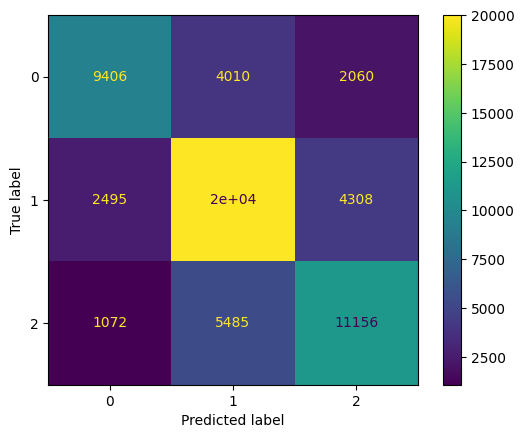

In [21]:
print("Best parameters found: ", grid_search.best_params_)
best_params = grid_search.best_params_

# Evaluate the best model
best_model = XGBClassifier(colsample_bytree = 1.0, gamma = 0, learning_rate = 0.2, max_depth = 7, n_estimators = 200,subsample = 0.8)
best_model.fit(X_train_tfidf, y_train)
preds = best_model.predict(X_test_tfidf)

# Display results
print(classification_report(y_test, preds, target_names=label_encoder.classes_))
ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.show()